In [286]:
import pysam 
import vcf as pyvcf
from pyfasta import Fasta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
vcf = pyvcf.Reader(open('/home/alexgri/Desktop/indels/GoldenStandard_OurAlgorithms/gcat_set_059-ensemble.vcf', 'r'))
ref = Fasta('/home/alexgri/Desktop/indels/human_g1k_v37.fasta')

In [287]:
def def_ref_chrom_name(string):
    chromosomes = ['','1 dna:chromosome chromosome:GRCh37:1:1:249250621:1',
                   '2 dna:chromosome chromosome:GRCh37:2:1:243199373:1',
                   '3 dna:chromosome chromosome:GRCh37:3:1:198022430:1',
                   '4 dna:chromosome chromosome:GRCh37:4:1:191154276:1',
                   '5 dna:chromosome chromosome:GRCh37:5:1:180915260:1',
                   '6 dna:chromosome chromosome:GRCh37:6:1:171115067:1',
                   '7 dna:chromosome chromosome:GRCh37:7:1:159138663:1',
                   '8 dna:chromosome chromosome:GRCh37:8:1:146364022:1',
                   '9 dna:chromosome chromosome:GRCh37:9:1:141213431:1',
                   '10 dna:chromosome chromosome:GRCh37:10:1:135534747:1',
                   '11 dna:chromosome chromosome:GRCh37:11:1:135006516:1',
                   '12 dna:chromosome chromosome:GRCh37:12:1:133851895:1',
                   '13 dna:chromosome chromosome:GRCh37:13:1:115169878:1',
                   '14 dna:chromosome chromosome:GRCh37:14:1:107349540:1',
                   '15 dna:chromosome chromosome:GRCh37:15:1:102531392:1',
                   '16 dna:chromosome chromosome:GRCh37:16:1:90354753:1',
                   '17 dna:chromosome chromosome:GRCh37:17:1:81195210:1',
                   '18 dna:chromosome chromosome:GRCh37:18:1:78077248:1',
                   '19 dna:chromosome chromosome:GRCh37:19:1:59128983:1',
                   '20 dna:chromosome chromosome:GRCh37:20:1:63025520:1',
                   '21 dna:chromosome chromosome:GRCh37:21:1:48129895:1',
                   '22 dna:chromosome chromosome:GRCh37:22:1:51304566:1',
                   'X dna:chromosome chromosome:GRCh37:X:1:155270560:1',
                   'Y dna:chromosome chromosome:GRCh37:Y:2649521:59034049:1']
    if (string!='X' and string!='Y'):
        return chromosomes[int(string)]
    elif (string=='X'):
        return chromosomes[23]
    elif (string=='Y'):
        return chromosomes[24]

На каждый вызов в этой функции инициализируется массив, а потом проверяются еще условия. Тут легче было бы сделать словарик, или, как это правильно называется, хэш-таблицу. Почитай про dict(). Так ты обойдешься без функций, условий и ускоришь эту часть кода в сотни раз. 

In [288]:
def count_freq(nuc,N,direction):
    vcf = pyvcf.Reader(open('/home/alexgri/Desktop/indels/GoldenStandard_OurAlgorithms/gcat_set_059-ensemble.vcf', 'r'))
    ref = Fasta('/home/alexgri/Desktop/indels/human_g1k_v37.fasta')
    if (nuc!='A' and nuc!='T' and nuc!='G' and nuc!='C'):
        return 0
    if N<=0:
        return 0
    if (direction!='right' and direction!='left'):
        return 0
    nuc_numb = 0
    overall_numb = 0
    if (direction=='left'):
        for record in vcf:
            if (len(record.REF)!=1 or len(record.ALT[0])!=1): 
                chrom = def_ref_chrom_name(record.CHROM)
                #print record
                #print ref[chrom][record.POS-1-N:record.POS-1+len(record.REF)]
                #print ref[chrom][record.POS-1-N:record.POS-1+len(record.REF)].count(nuc)
                nuc_numb += ref[chrom][record.POS-1-N:record.POS-1].count(nuc)
                overall_numb += N
    elif (direction=='right'):
        for record in vcf:
            if (len(record.REF)!=1 or len(record.ALT[0])!=1): 
                chrom = def_ref_chrom_name(record.CHROM)
                #print record
                #print ref[chrom][record.POS-1:record.POS-1+len(record.REF)+N]
                #print ref[chrom][record.POS-1:record.POS-1+len(record.REF)+N].count(nuc)
                nuc_numb += ref[chrom][record.POS+len(record.REF)-1:record.POS-1+len(record.REF)+N].count(nuc)
                overall_numb += N
    return float(nuc_numb)/overall_numb
def count_homopolymers_right():
    vcf = pyvcf.Reader(open('/home/alexgri/Desktop/indels/GoldenStandard_OurAlgorithms/gcat_set_059-ensemble_head.vcf', 'r'))
    ref = Fasta('/home/alexgri/Desktop/indels/human_g1k_v37.fasta')
    df = pd.DataFrame(columns=range(100),index=range(100)).fillna(0)
    for record in vcf:
        if (len(record.REF)!=1 or len(record.ALT[0])!=1): 
            chrom = def_ref_chrom_name(record.CHROM)
            i = 1
            while (ref[chrom][record.POS+len(record.REF)-1+i:record.POS+len(record.REF)+i]==ref[chrom][record.POS-1+len(record.REF):record.POS+len(record.REF)]):
                i+=1
            df.loc[abs(len(record.REF)-len(record.ALT[0])),i] += 1
    return df
def count_homopolymers_left():
    vcf = pyvcf.Reader(open('/home/alexgri/Desktop/indels/GoldenStandard_OurAlgorithms/gcat_set_059-ensemble_head.vcf', 'r'))
    ref = Fasta('/home/alexgri/Desktop/indels/human_g1k_v37.fasta')
    df = pd.DataFrame(columns=range(100),index=range(100)).fillna(0)
    for record in vcf:
        if (len(record.REF)!=1 or len(record.ALT[0])!=1): 
            chrom = def_ref_chrom_name(record.CHROM)
            i = 1
            while (ref[chrom][record.POS-2-i:record.POS-1-i]==ref[chrom][record.POS-2:record.POS-1]):
                i+=1
            df.loc[abs(len(record.REF)-len(record.ALT[0])),i] += 1
    return df

1.Ты сэкономишь процессорное (и свое) время, если будешь считать count_homopolymers_left и count_homopolymers_right за один проход. (в одной функции) В питоне можно возвращаться сразу несколько структур из функции:


def rdf:

    return df1, df2

df_x, df_y = rdf

А еще лучше - для каждого индела в dataframe хранить 2 колонки - количество гомополимеров справа и слева.

2. строчка while (ref[chrom][record.POS+len(record.REF)-1+i:record.POS+len(record.REF)+i]==ref[chrom][record.POS-1+len(record.REF):record.POS+len(record.REF)]): - нечитаемая. Разве len(record.REF) - это что? В случае делеции - длина делеции (формальная), а в случае инсерции?

Разве нельзя просто обращаться ref[chrom][record.POS+len(record.REF)+i], чтобы получить 1 букву?

Вот это выражение: ref[chrom][record.POS-1+len(record.REF):record.POS+len(record.REF)] - всегда константная строчка, не зависит от i. Зачем ее каждый раз вычислять? Сохрани в отдельную переменную перед циклом. 
df.loc[abs(len(record.REF)-len(record.ALT[0])),i] += 1 - не осознал. Разве len(record.ALT[0]) не тождественно равно 1?

In [185]:
df_right = count_homopolymers_right()
df_left = count_homopolymers_left()

In [307]:
print df_right.as_matrix()[1:10,1:10]
print df_left.as_matrix()[1:10,1:10]


[[29967 13937 20074 19547 17354 10770  5350  3055  2038]
 [ 1525   577   619   419   225    92    57    55   102]
 [  371   138    52    52    16    10     5    10    17]
 [  200    47    45     7    15     8     3     0     3]
 [   69    35    14    14     9    14    14     1     0]
 [   66     9     6     8     5    14     2     1     0]
 [   27     6     2     3     1     2     1     0     0]
 [   33     9     2     1     0     0     1     0     0]
 [   19     6     2     0     0     0     0     0     0]]
[[85988 23518  8861  3540  1285   310    97    45    16]
 [ 2217  1001   571   241   108    44    16     5     4]
 [  547   153    75    38    19     8    10     2     4]
 [  244    59    23     9     8     3     1     2     1]
 [  118    30    13     6     2     3     2     0     0]
 [   89    14     7     1     1     0     0     0     0]
 [   30     5     3     3     0     1     0     0     0]
 [   35     6     4     1     1     0     0     0     0]
 [   17     5     3     1     

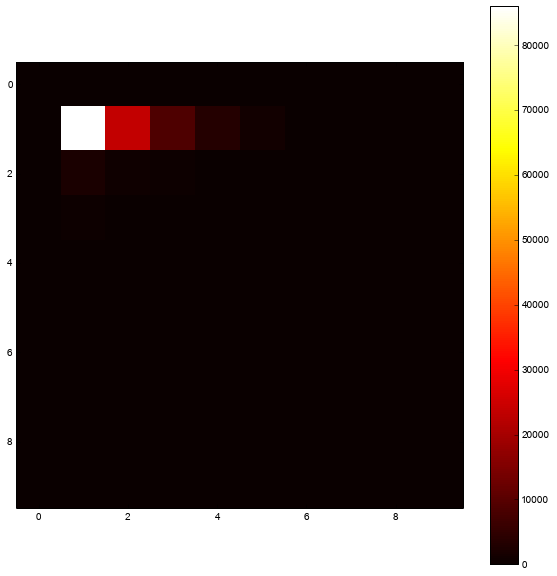

In [216]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10), dpi=500)
plt.imshow(df_left.as_matrix()[:10,:10], cmap='hot', interpolation="nearest")
plt.colorbar()
plt.show()

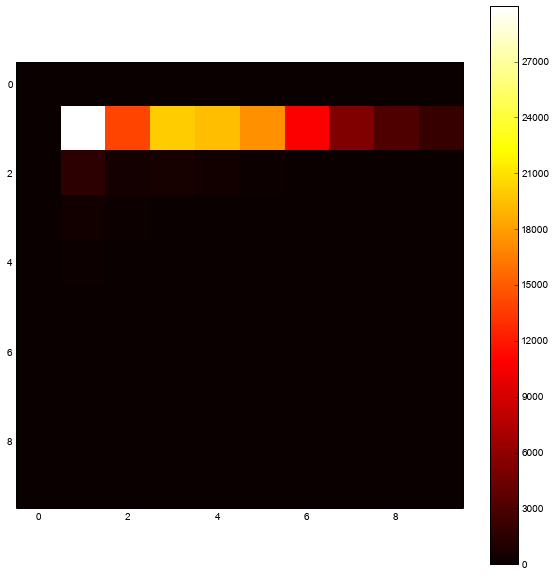

In [217]:
fig = plt.figure(figsize=(10, 10), dpi=500)
plt.imshow(df_right.as_matrix()[:10,:10], cmap='hot', interpolation="nearest")
plt.colorbar()
plt.show()

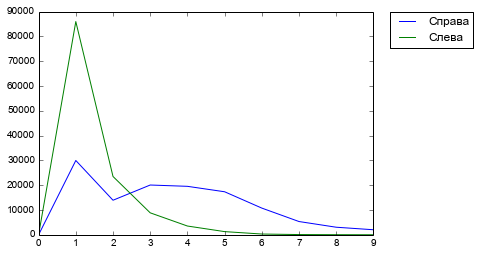

In [223]:
plt.plot(df_right.as_matrix()[1,:10],label=u"Справа")
plt.plot(df_left.as_matrix()[1,:10],label=u"Слева")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

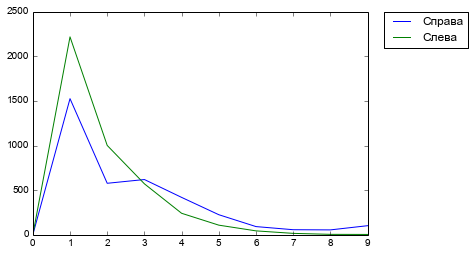

In [225]:
plt.plot(df_right.as_matrix()[2,:10],label=u"Справа")
plt.plot(df_left.as_matrix()[2,:10],label=u"Слева")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [289]:
freq_left_A = np.ndarray(0)
freq_left_T = np.ndarray(0)
freq_left_G = np.ndarray(0)
freq_left_C = np.ndarray(0)
freq_right_A = np.ndarray(0)
freq_right_T = np.ndarray(0)
freq_right_G = np.ndarray(0)
freq_right_C = np.ndarray(0)
for i in np.arange(10)+1:
    print i
    freq_left_A = np.append(freq_left_A,count_freq('A',i,'left'))
    freq_left_T = np.append(freq_left_T,count_freq('T',i,'left'))
    freq_left_G = np.append(freq_left_G,count_freq('G',i,'left'))
    freq_left_C = np.append(freq_left_C,count_freq('C',i,'left'))
    freq_right_A = np.append(freq_right_A,count_freq('A',i,'right'))
    freq_right_T = np.append(freq_right_T,count_freq('T',i,'right'))
    freq_right_G = np.append(freq_right_G,count_freq('G',i,'right'))
    freq_right_C = np.append(freq_right_C,count_freq('C',i,'right'))

1
2
3
4
5
6
7
8
9
10


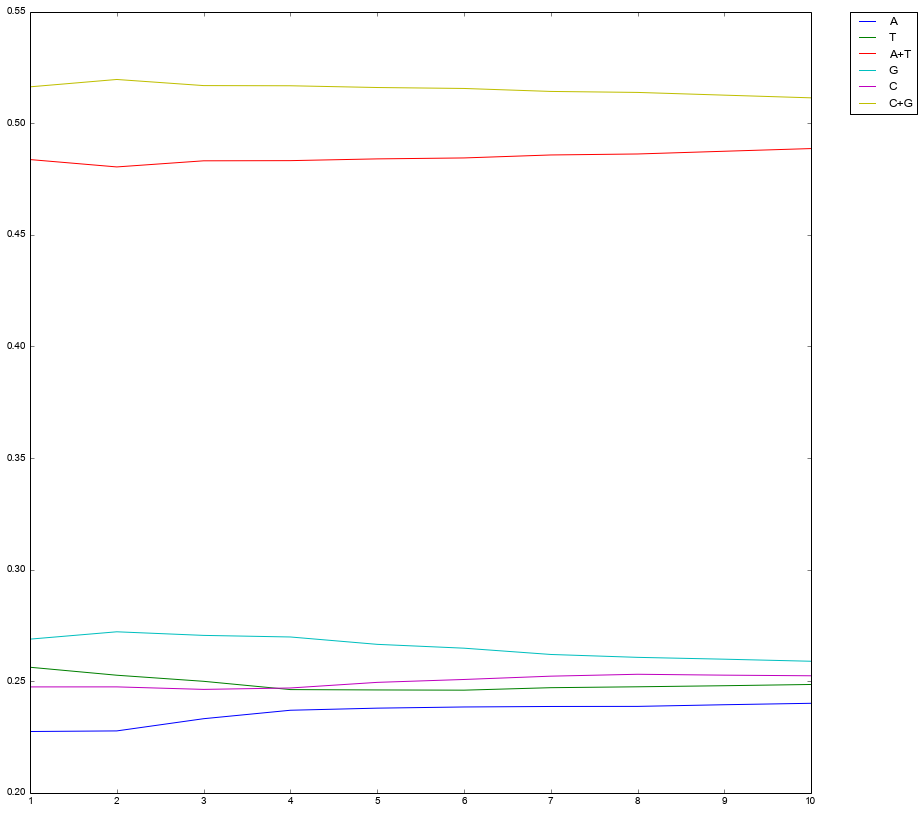

In [302]:
plt.figure(figsize=(14, 14), dpi=500)
plt.plot(np.arange(10)+1,freq_left_A,label=u"A")
plt.plot(np.arange(10)+1,freq_left_T,label=u"T")
plt.plot(np.arange(10)+1,freq_left_T+freq_left_A,label=u"A+T")
plt.plot(np.arange(10)+1,freq_left_G,label=u"G")
plt.plot(np.arange(10)+1,freq_left_C,label=u"C")
plt.plot(np.arange(10)+1,freq_left_C+freq_left_G,label=u"C+G")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

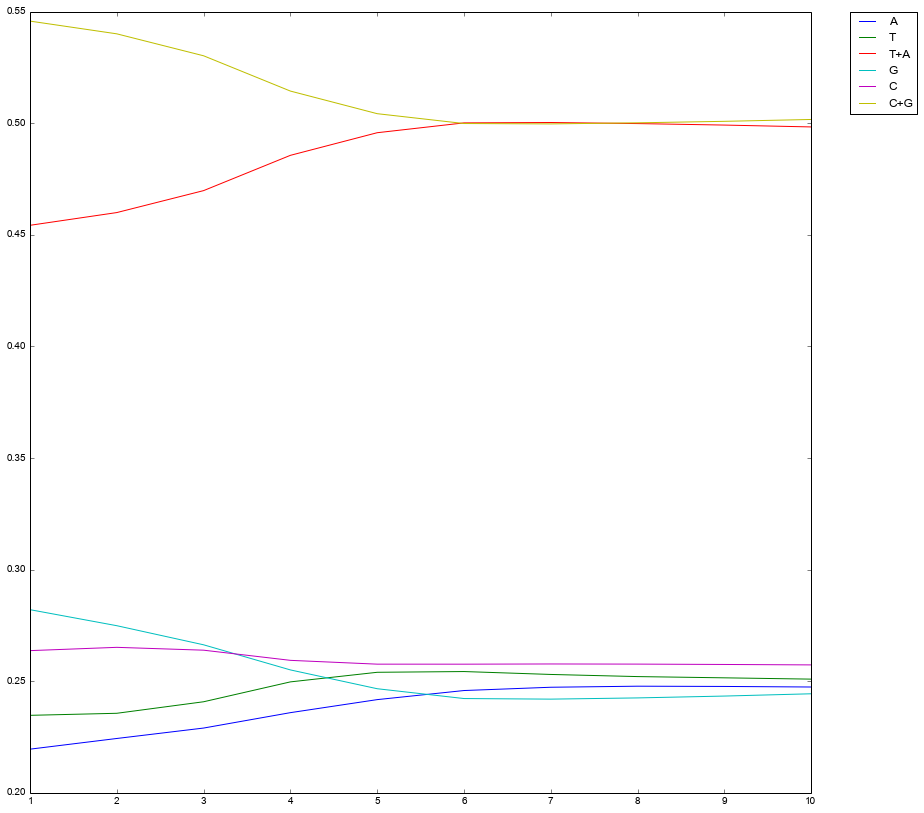

In [303]:
plt.figure(figsize=(14, 14), dpi=500)
plt.plot(np.arange(10)+1,freq_right_A,label=u"A")
plt.plot(np.arange(10)+1,freq_right_T,label=u"T")
plt.plot(np.arange(10)+1,freq_right_T+freq_right_A,label=u"T+A")
plt.plot(np.arange(10)+1,freq_right_G,label=u"G")
plt.plot(np.arange(10)+1,freq_right_C,label=u"C")
plt.plot(np.arange(10)+1,freq_right_C+freq_right_G,label=u"C+G")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
samfile = pysam.AlignmentFile("/home/alexgri/Desktop/indels/GoldenStandard_OurAlgorithms/gcat_set_059-ready.bam", "rb")
#for read in samfile.fetch('1', 1019890, 1019891):
#     print read


for pileupcolumn in samfile.pileup('1', pos, pos+1):
    if (pileupcolumn.pos==pos or pileupcolumn.pos==pos+1 or pileupcolumn.pos==pos-1):
        print ("\ncoverage at base %s = %s" %(pileupcolumn.pos, pileupcolumn.n))
        for pileupread in pileupcolumn.pileups:
            #print pileupread.alignment.seq
            if not pileupread.is_del and not pileupread.is_refskip and (pos-pileupread.alignment.pos>=0) and (pos-pileupread.alignment.pos<len(pileupread.alignment.seq)):
                print ('\tbase in read %s = %s' %(pileupread.alignment.query_name,pileupread.alignment.query_sequence[pos - pileupread.alignment.pos]))
samfile.close()